### This file is used to predict all ratings in user_item matrix and find top k recommendations for any user

#### Read user and item csv files

In [1]:
import pandas as pd
import gzip
from PIL import Image
from PIL import ImageOps
import urllib.request as urllib
import urllib.error as err

import io
import numpy as np

def parse(path):
    g = gzip.open(path, 'rb')
    for line in g:
        yield eval(line)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

In [2]:
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"
5,A27UF1MSF3DB2,0000031887,"C-Lo ""Cynthia""","[0, 0]",I received this today and I'm not a fan of it ...,4.0,It's ok,1396224000,"03 31, 2014"
6,A16GFPNVF4Y816,0000031887,design maven,"[0, 0]",Bought this as a backup to the regular ballet ...,5.0,Great for dress-up and for ballet practice,1399075200,"05 3, 2014"
7,A2M2APVYIB2U6K,0000031887,Jamie P.,"[0, 0]",Great tutu for a great price. It isn't a &#34;...,5.0,Great value,1356220800,"12 23, 2012"
8,A1NJ71X3YPQNQ9,0000031887,JBerger,"[0, 0]","My daughter liked this, and it with her costum...",4.0,Good,1384041600,"11 10, 2013"
9,A3EERSWHAI6SO,0000031887,"Jeffrey Hollingshead ""Jillian hollingshead""","[7, 8]",For what I paid for two tutus is unbeatable an...,5.0,WOW !! ..is all I have to say!,1349568000,"10 7, 2012"


In [3]:
user_item_data = df[['reviewerID','asin','overall','reviewTime','unixReviewTime']]

In [4]:
user_item_data.size

1393385

In [5]:
user_item_data.columns = ["User_Id", "Item_Id", "Rating", "TimeStamp","TimeStamp2"]

In [6]:
user_item_data.head()

,User_Id,Item_Id,Rating,TimeStamp,TimeStamp2
0,A1KLRMWW2FWPL4,0000031887,5.0,"02 12, 2011",1297468800
1,A2G5TCU2WDFZ65,0000031887,5.0,"01 19, 2013",1358553600
2,A1RLQXYNCMWRWN,0000031887,5.0,"01 4, 2013",1357257600
3,A8U3FAMSJVHS5,0000031887,5.0,"04 27, 2014",1398556800
4,A3GEOILWLK86XM,0000031887,5.0,"03 15, 2014",1394841600


#### No. of Unique Users

In [7]:
len(user_item_data["User_Id"].unique())

39387

#### No. of Unique Items

In [8]:
len(user_item_data["Item_Id"].unique())

23033

#### Subset2

In [9]:
top_item = user_item_data.groupby(['Item_Id'])['Rating'].count().reset_index().sort_values(['Rating'], ascending=False).head(1000) 
top_item = top_item["Item_Id"].tolist()

In [10]:
subset_user_item_data = user_item_data.loc[(user_item_data["Item_Id"].isin(top_item))]
len(subset_user_item_data["Item_Id"].unique())

1000

In [11]:
top_user = subset_user_item_data.groupby(['User_Id'])['Rating'].count().reset_index().sort_values(['Rating'], ascending=False).head(1000)
top_user = top_user["User_Id"].tolist()

In [12]:
subset_user_item_data = subset_user_item_data.loc[(user_item_data["User_Id"].isin(top_user))]
len(subset_user_item_data["User_Id"].unique())

1000

In [13]:
len(subset_user_item_data["Item_Id"].unique())

978

#### Create test set

In [14]:
import random
def create_testdataset(dataset,k):
    test_df = pd.DataFrame(columns=["User_Id","Item_Id","Rating"])
    for i in range(0,k):
        index = random.choice(dataset.index.values.tolist())
        user = dataset.loc[index,'User_Id']
        item = dataset.loc[index,'Item_Id']
        rating = dataset.loc[index,'Rating']
        df = pd.DataFrame([[user,item,rating]],columns=["User_Id","Item_Id","Rating"])
        test_df = test_df.append(df)
    return test_df

In [15]:
test_df = create_testdataset(subset_user_item_data,5)
test_df = test_df.reset_index()
del test_df['index']
test_df.head(5)

,User_Id,Item_Id,Rating
0,A1TPTRMYHOFPES,B00DMWQV38,4.0
1,A2Q3JAF2FM9O4S,B0031U0PO2,3.0
2,A26IRZJV6D220M,B0007LPM3W,5.0
3,A39J4VW83TK90C,B000CNAAAA,5.0
4,A1IXH6DG8ORH0U,B005T8V0NO,2.0


#### Create user_item matrix and check sparsity

In [16]:
import scipy.sparse
from scipy.sparse import csr_matrix
import sklearn

In [17]:
#Create user-item matrix from train set dataframe
subset_user_item_data = subset_user_item_data[["User_Id","Item_Id","Rating"]]
user_item_pivot = subset_user_item_data.pivot(index="User_Id",columns="Item_Id", values="Rating")
userId = user_item_pivot.index
itemId = user_item_pivot.columns

In [18]:
#Remove the ratings of rows in test set from train set
for i in range(0,test_df.shape[0]):
    user_item_pivot.loc[test_df.User_Id[i]][test_df.Item_Id[i]] = np.nan

In [19]:
#Create matrix filled with zeros and not filled with zeros
user_item_matrix = csr_matrix(user_item_pivot.values)
user_item_pivot_filled_zeros = user_item_pivot.fillna(0)
user_item_matrix_filled_zeros = csr_matrix(user_item_pivot_filled_zeros.values)

In [20]:
#Calculate sparsity of user_item matrix
missing = pd.DataFrame(np.isnan(user_item_pivot).sum()/np.prod(user_item_pivot.shape))
missing = missing.reset_index()
missing.columns = ["Item_Id", "percent_missing"]
missing.percent_missing.sum()

0.9931134969325153

### Baseline Model

#### Matrix Factorization

In [21]:
#calculate mean of ratings for each user
user_item_pivot_base = user_item_pivot.copy(deep=True)

In [22]:
#calculate mean of ratings for each user
user_item_pivot_base['Mean'] = user_item_pivot_base.mean(axis=1)
#store in another matrix and subract mean column from all other columns in user-item matrix
user_item_pivot2_base = user_item_pivot_base.copy(deep=True)
user_item_pivot2_base = user_item_pivot2_base.sub(user_item_pivot_base['Mean'].reset_index().Mean.tolist(),axis=0)
user_item_pivot2_base['Mean'] = user_item_pivot_base['Mean']
user_item_pivot2_base.head()

Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E,Mean
User_Id,,,,,,,,,,,,,,,,,,,,,
A0718784TOWF9DX1DOFD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.500000
A100WFKYVRPVX7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
A103979529MRJY0U56QI4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.375000
A106GRKSYBW4X4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.625000
A1079CQTAUIX6J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.428571


In [23]:
user_item_demeaned = user_item_pivot2_base.fillna(0).iloc[:,:-1]

In [24]:
#use matrix factorization to convert user-item matrix to new latent space
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(user_item_demeaned, k = 3)
sigma = np.diag(sigma)

In [25]:
#calculate predicted ratings using reduced latent space matrices
all_user_predicted_ratings_base = np.dot(np.dot(U, sigma), Vt) + np.array(user_item_pivot_base['Mean'].reset_index().Mean.tolist()).reshape(-1,1)

In [26]:
#Create user-item matrix of predictions
user_item_predictions_model_base = pd.DataFrame(all_user_predicted_ratings_base, columns = user_item_demeaned.columns)
user_item_predictions_model_base.index = user_item_demeaned.index

In [27]:
user_item_predictions_model_base

Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F2ZX4XS,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E
User_Id,,,,,,,,,,,,,,,,,,,,,
A0718784TOWF9DX1DOFD,3.499997,3.499997,3.500001,3.500001,3.499999,3.499999,3.500000,3.499998,3.499994,3.500000,...,3.500016,3.499998,3.500000,3.500000,3.499981,3.499999,3.500007,3.499999,3.500007,3.500000
A100WFKYVRPVX7,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A103979529MRJY0U56QI4,4.375392,4.375660,4.374890,4.374782,4.375389,4.375102,4.374968,4.375133,4.374723,4.374969,...,4.375911,4.376459,4.371413,4.375001,4.369303,4.375166,4.374219,4.375117,4.372704,4.375111
A106GRKSYBW4X4,4.624297,4.626266,4.624657,4.624769,4.625123,4.625448,4.624973,4.624351,4.625672,4.624934,...,4.614719,4.617712,4.630465,4.625005,4.638114,4.624935,4.633630,4.624989,4.627760,4.624721
A1079CQTAUIX6J,4.428587,4.428523,4.428584,4.428581,4.428563,4.428556,4.428573,4.428589,4.428548,4.428574,...,4.428895,4.428781,4.428436,4.428571,4.428203,4.428571,4.428317,4.428570,4.428514,4.428579
A10DB98EONP1XP,4.833327,4.833341,4.833331,4.833331,4.833335,4.833336,4.833333,4.833328,4.833328,4.833333,...,4.833298,4.833296,4.833343,4.833333,4.833350,4.833333,4.833388,4.833333,4.833344,4.833332
A10MN9X0EH4XEH,3.333333,3.333328,3.333335,3.333334,3.333332,3.333331,3.333333,3.333334,3.333326,3.333334,...,3.333383,3.333358,3.333309,3.333333,3.333264,3.333333,3.333309,3.333333,3.333326,3.333334
A10UHQH1YL5Q6B,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A110M2KRZB0IS3,4.333389,4.333296,4.333341,4.333343,4.333327,4.333323,4.333337,4.333381,4.333419,4.333335,...,4.333376,4.333532,4.333360,4.333333,4.333527,4.333342,4.332976,4.333336,4.333261,4.333337


#### Evaluation Metrics

In [28]:
#prints predicted and orginal ratings given test set and array of predicted ratings for user-item combinations in test set
def print_ratings(test_df,user_item_predicted):
    user_item_predicted_array = []
    for i in range(0,test_df.shape[0]):
        print("User ID:", test_df.User_Id[i])
        print("Predicted Ratings:", user_item_predicted.loc[test_df.User_Id[i]][test_df.Item_Id[i]])
        print("Original Ratings:",test_df.Rating[i])
        print("\n")
        user_item_predicted_array.append(user_item_predicted.loc[test_df.User_Id[i]][test_df.Item_Id[i]])
    
    return np.array(user_item_predicted_array)

In [29]:
#returns rmse given predicted and observed rating arrays
def calculate_rmse(predicted_rating,observed_rating):
    rmse = np.sqrt((np.sum(np.square(predicted_rating-observed_rating)))/(len(observed_rating)))
    return rmse

In [30]:
#returns mae given predicted and observed rating arrays
def calculate_mae(predicted_rating,observed_rating):
    mae = (np.sum(abs(predicted_rating-observed_rating)))/(len(observed_rating))
    return mae

In [31]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predictions_model_base)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: A1TPTRMYHOFPES
Predicted Ratings: 4.3012819428024205
Original Ratings: 4.0


User ID: A2Q3JAF2FM9O4S
Predicted Ratings: 4.399999893645092
Original Ratings: 3.0


User ID: A26IRZJV6D220M
Predicted Ratings: 4.1666667016719705
Original Ratings: 5.0


User ID: A39J4VW83TK90C
Predicted Ratings: 4.500000328664548
Original Ratings: 5.0


User ID: A1IXH6DG8ORH0U
Predicted Ratings: 3.7500033626828655
Original Ratings: 2.0


Root Mean Square Error for Test Data: 1.100702170262623
Mean Absolute Error for Test Data: 0.956923633758772


#### Coverage- Print catalog coverage and item coverage

In [32]:
#returns item coverage for dataset ie. percentage of items predicted from all items.
def calculate_items_coverage(k,user_item_predicted):
    items_recommended =[]
    for i in range(0,user_item_predicted.shape[0]):
        top_k_items=[]
        target_user = user_item_predicted.index[i]
        top_k_items=top_k_items_recommended(k,target_user,user_item_predicted)
        items_recommended.extend(top_k_items)
        
    items_recommended = np.unique(np.array(items_recommended)).tolist()
    print((items_recommended))
    items_coverage = len(items_recommended)/user_item_predicted.shape[1]
    return items_coverage

In [33]:
#returns top-k recommened items for any user
def top_k_items_recommended(k,userid,user_item_predicted):
    items_target = user_item_predicted.loc[userid].reset_index()
    top_k_items = items_target.sort_values(userid, ascending=False)[:k].Item_Id.tolist()
    return top_k_items

In [34]:
#returns catalog coverage for dataset ie. percentage of user-item pairs predicted from all possible user-item pairs
def calculate_catalog_coverage(k,user_item_predicted):
    total_user_item_pairs = user_item_predicted.shape[0]*user_item_predicted.shape[1]
    #since recommending items to all the users
    total_user_items_recommended = user_item_predicted.shape[0]*k
    coverage_ratio = total_user_items_recommended/total_user_item_pairs
    return coverage_ratio

In [80]:
calculate_catalog_coverage(10,user_item_predictions_model_base)

0.010224948875255624

In [81]:
calculate_items_coverage(10,user_item_predictions_model_base)

['B00005TQI7', 'B000H6AQ0Q', 'B000MFD9TC', 'B000QW6LE6', 'B002Q8AJSM', 'B002XVEEVA', 'B003QFXPN0', 'B003S7T8NM', 'B0049O53VO', 'B004S79EWG', 'B004Z1CZDK', 'B005002MN8', 'B005LERHD8', 'B005NGMBJE', 'B0064X9ZAI', 'B0064YY0DE', 'B00668BMW0', 'B0066C71G2', 'B0067GUM2W', 'B0067TMRO0', 'B0067UH3OI', 'B0068VM5T4', 'B006FCUNDG', 'B006UY80QG', 'B0078FXHNM', 'B007KQRSZM', 'B007RD9DS8', 'B007WNWEFC', 'B008NCYALM', 'B008RUOCJU', 'B008WYDP1C', 'B008X0EW44', 'B00ARGDD6K', 'B00ARWNVG6', 'B00BNB3A0W', 'B00CAMCNQ0', 'B00DM0587K', 'B00DM05AAU', 'B00DM05BC2', 'B00DM05BU4', 'B00DM05D5C', 'B00DM05FV4', 'B00DMWQJJY', 'B00DMWQK0W', 'B00DMWQKWA', 'B00DMWQLB0', 'B00DMWQOGC', 'B00DMWQOYY', 'B00DMWQQEW', 'B00DMWQV38', 'B00DMWQVJM', 'B00DNQIIE8', 'B00E1WD46U']


0.0541922290388548

### Content Based Model

#### Item-item neighbours- finds the 20 nearest neigbours for each item and predicts its rating using cosine similarity for each user

In [37]:
user_item_pivot_con0 = user_item_pivot.copy(deep=True)

#### Read csv file for vector representation of item using its image

In [38]:
feature_df0 = pd.read_csv("item_vector_image3.csv")
feature_df0 = feature_df0[["asin","img_vector"]]
feature_df0.head()

,asin,img_vector
0,0000031887,"61.04323959350586,10.855009078979492,67.806251..."
1,0123456479,"69.39546203613281,28.37046241760254,44.9137649..."
2,1608299953,"59.34332275390625,30.055545806884766,47.660144..."
3,1617160377,"59.33428192138672,30.18754005432129,47.7793426..."
4,B00001W0KA,"71.78907775878906,10.117408752441406,79.442283..."


In [39]:
feature_df0_list2=subset_user_item_data['Item_Id'].tolist()
feature_df0_list2_full = feature_df0["asin"].tolist()

In [40]:
feature_df0_list2

['B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000074RL3',
 'B000074RL3',
 'B000074RL3',
 'B0000868O9',
 'B0000868O9',
 'B0000868O9',
 'B0000868O9',
 'B0000868O9',
 'B0000868O9',
 'B0000868O9',
 'B0000868O9',
 'B0000868O9',
 'B0000868O9',
 'B000086910',
 'B000086910',
 'B000086910',
 'B000086910',
 'B000086910',
 'B000086910',
 'B000086910',
 'B000086910',
 'B000086910',
 'B000086910',
 'B000086910',
 'B000086910',
 'B00008ECKG',
 'B00008ECKG',
 'B00008ECKG',
 'B00008ECKG',
 'B00008ECKG',
 'B00008ECKG',
 'B00008KH9C',
 'B00008KH9C',
 'B00008KH9C',
 'B00008KH9C',
 'B00009ZM7Z',
 'B00009ZM7Z',
 'B00009ZM7Z',
 'B00009ZM7Z',
 'B00009ZM7Z',
 'B0000ANDU4',
 'B0000ANDU4',
 'B0000ANDU4',
 'B0000ANECK',
 'B0000ANECK',
 'B0000ANECK',
 'B0000ANECK',
 'B0000ANHST',
 'B0000ANHST',
 'B0000ANHST',
 'B0000ANHST',
 'B0000ANHST',
 'B0000ANHST',
 'B0000ANH

#### Create a list of vector reprentations of items in the subset

In [41]:
feature_df0_list =[]
for i in range(0,len(feature_df0_list2)):
    temp = feature_df0.loc[feature_df0['asin'] == feature_df0_list2[i], 'img_vector'].tolist()[0].split(",")
    feature_df0_list.append(list(map(float,temp)))
feature_df0_list

[[66.46489715576172,
  10.017066955566406,
  49.306121826171875,
  0.0,
  104.55612182617188,
  13.135965347290039,
  90.8963851928711,
  0.0,
  86.54340362548828,
  25.08198356628418,
  58.448333740234375,
  6.375067234039307,
  40.21644592285156,
  0.0,
  0.0,
  0.0],
 [66.46489715576172,
  10.017066955566406,
  49.306121826171875,
  0.0,
  104.55612182617188,
  13.135965347290039,
  90.8963851928711,
  0.0,
  86.54340362548828,
  25.08198356628418,
  58.448333740234375,
  6.375067234039307,
  40.21644592285156,
  0.0,
  0.0,
  0.0],
 [66.46489715576172,
  10.017066955566406,
  49.306121826171875,
  0.0,
  104.55612182617188,
  13.135965347290039,
  90.8963851928711,
  0.0,
  86.54340362548828,
  25.08198356628418,
  58.448333740234375,
  6.375067234039307,
  40.21644592285156,
  0.0,
  0.0,
  0.0],
 [66.46489715576172,
  10.017066955566406,
  49.306121826171875,
  0.0,
  104.55612182617188,
  13.135965347290039,
  90.8963851928711,
  0.0,
  86.54340362548828,
  25.08198356628418,
  

#### Create pivot table for predicted ratings

In [42]:
user_item_df = pd.DataFrame(columns=["User_Id","Item_Id","Rating"])
user_item_df['User_Id'] = subset_user_item_data['User_Id']
user_item_df['Item_Id'] = subset_user_item_data['Item_Id']
user_item_df['Rating'] = [0]*subset_user_item_data.shape[0]
user_item_predicted_con = user_item_df.pivot(index="User_Id",columns="Item_Id", values="Rating")
user_item_predicted_con2 = user_item_df.pivot(index="User_Id",columns="Item_Id", values="Rating")

#### Train nearest items model on list of item vectors of subset

In [43]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=21).fit(feature_df0_list)

#### Finds the nearest neighbours of each item rated by given user and predicts their rating based on cosine similraity to items rated by given user for all users

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import math
for i in range(0,user_item_pivot_con0.shape[0]):
    print("User:",i)
    target_user = user_item_pivot_con0.index[i]
    items_target = user_item_pivot_con0.loc[target_user]
    items_target = items_target.reset_index()
    items_target_rated = items_target[~(items_target[target_user].isna())]
    neighbours=[]
    features_neighbours = []
    rated_labels = []
    rated = []
    rated_features=[]
    for j in items_target_rated['Item_Id']:
        feature = feature_df0.loc[feature_df0['asin'] == j, 'img_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        distances, indices = nbrs.kneighbors([feature])
        rated.append(j)
        rated_features.append(feature)
        rated_labels.append(user_item_pivot_con0.loc[target_user][j])
        for i in indices[0]:
            if feature_df0_list2[i] != j:
                if feature_df0_list2[i] not in neighbours:
                    neighbours.append(feature_df0_list2[i])
                    features_neighbours.append(feature_df0_list[i])
    for k in range(0,len(neighbours)):
        sum_rating_nn = 0.0
        similarity_nn = 0.0
        for m in range(0,len(rated)):
            sum_rating_nn = sum_rating_nn+cosine_similarity([features_neighbours[k]],[rated_features[m]])[0][0]*rated_labels[m]
            similarity_nn = similarity_nn + abs(cosine_similarity([features_neighbours[k]],[rated_features[m]])[0][0])
        predicted_rating = sum_rating_nn/similarity_nn
        user_item_pivot_con0.loc[target_user][neighbours[k]]=predicted_rating
        user_item_predicted_con.loc[target_user][neighbours[k]]=predicted_rating
        user_item_predicted_con2.loc[target_user][neighbours[k]]=predicted_rating
print(user_item_pivot_con0)

User: 0
User: 1
User: 2
User: 3
User: 4
User: 5
User: 6
User: 7
User: 8
User: 9
User: 10
User: 11
User: 12
User: 13
User: 14
User: 15
User: 16
User: 17
User: 18
User: 19
User: 20
User: 21
User: 22
User: 23
User: 24
User: 25
User: 26
User: 27
User: 28
User: 29
User: 30
User: 31
User: 32
User: 33
User: 34
User: 35
User: 36
User: 37
User: 38
User: 39
User: 40
User: 41
User: 42
User: 43
User: 44
User: 45
User: 46
User: 47
User: 48
User: 49
User: 50
User: 51
User: 52
User: 53
User: 54
User: 55
User: 56
User: 57
User: 58
User: 59
User: 60
User: 61
User: 62
User: 63
User: 64
User: 65
User: 66
User: 67
User: 68
User: 69
User: 70
User: 71
User: 72
User: 73
User: 74
User: 75
User: 76
User: 77
User: 78
User: 79
User: 80
User: 81
User: 82
User: 83
User: 84
User: 85
User: 86
User: 87
User: 88
User: 89
User: 90
User: 91
User: 92
User: 93
User: 94
User: 95
User: 96
User: 97
User: 98
User: 99
User: 100
User: 101
User: 102
User: 103
User: 104
User: 105
User: 106
User: 107
User: 108
User: 109
User: 110


User: 833
User: 834
User: 835
User: 836
User: 837
User: 838
User: 839
User: 840
User: 841
User: 842
User: 843
User: 844
User: 845
User: 846
User: 847
User: 848
User: 849
User: 850
User: 851
User: 852
User: 853
User: 854
User: 855
User: 856
User: 857
User: 858
User: 859
User: 860
User: 861
User: 862
User: 863
User: 864
User: 865
User: 866
User: 867
User: 868
User: 869
User: 870
User: 871
User: 872
User: 873
User: 874
User: 875
User: 876
User: 877
User: 878
User: 879
User: 880
User: 881
User: 882
User: 883
User: 884
User: 885
User: 886
User: 887
User: 888
User: 889
User: 890
User: 891
User: 892
User: 893
User: 894
User: 895
User: 896
User: 897
User: 898
User: 899
User: 900
User: 901
User: 902
User: 903
User: 904
User: 905
User: 906
User: 907
User: 908
User: 909
User: 910
User: 911
User: 912
User: 913
User: 914
User: 915
User: 916
User: 917
User: 918
User: 919
User: 920
User: 921
User: 922
User: 923
User: 924
User: 925
User: 926
User: 927
User: 928
User: 929
User: 930
User: 931
User: 932


#### The sparsity of user-item matrix is reduced significantly

In [45]:
user_item_pivot_con0

Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F2ZX4XS,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E
User_Id,,,,,,,,,,,,,,,,,,,,,
A0718784TOWF9DX1DOFD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WFKYVRPVX7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103979529MRJY0U56QI4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A106GRKSYBW4X4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1079CQTAUIX6J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10DB98EONP1XP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10MN9X0EH4XEH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10UHQH1YL5Q6B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A110M2KRZB0IS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Doc2Vec- This section uses the user-item matrix created by item-item neighbours model. We have about 40 training examples of items rated by every user. We use random forest regressor to predict the remaining ratings for each user by training a regression model for each user with training examples of items rated. Each number in vector representation using Doc2vec model is used a feature and the rating is the label. We have the vector representation of all images. Thus the model predicts the rating for unrated items based on its vector represenation

#### Create a copy of user-item matrix predicted by item-item neighbours model

In [46]:
user_item_pivot_con = user_item_pivot_con0.copy(deep=True)

#### Read vector representation of each item based on textual information of item

In [47]:
feature_df = pd.read_csv("item_vector2.csv")
feature_df = feature_df[["asin","words_vector"]]

In [48]:
feature_df.head()

,asin,words_vector
0,0000031887,"-0.13755247,-0.23854996,0.2599594,0.68409824,0..."
1,0123456479,"-0.18328372,-1.0237274,-0.111990996,0.7746652,..."
2,1608299953,"-0.018653307,0.0006199626,0.06554515,0.0078448..."
3,1617160377,"-0.007659583,-0.0036083309,0.02717292,-0.01544..."
4,B00001W0KA,"-0.18820827,-0.37920812,0.344533,0.61592835,0...."


#### Cross-validation and hyper parameter tuning of Random Forest Regressor model using GridSearchCV

In [49]:
i=20
target_user = user_item_pivot_con.index[i]
items_target = user_item_pivot_con.loc[target_user]
items_target = items_target.reset_index()
items_target_na = items_target[items_target[target_user].isna()]
items_target_rated = items_target[~(items_target[target_user].isna())]
features = []
labels = []
for j in items_target_rated['Item_Id']:
    feature = feature_df.loc[feature_df['asin'] == j, 'words_vector'].tolist()[0].split(",")
    feature = list(map(float, feature))
    features.append(feature)
    labels.append(user_item_pivot_con.loc[target_user][j])
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2,4,8,10],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(features,labels)
grid_search.best_params_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  2.8min finished
C:\Users\Kiran\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

#### Create Random Forest Regressor model for each user and predict unrated items

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
for i in range(0,user_item_pivot_con.shape[0]):
    print("User:",i)
    target_user = user_item_pivot_con.index[i]
    items_target = user_item_pivot_con.loc[target_user]
    items_target = items_target.reset_index()
    items_target_na = items_target[items_target[target_user].isna()]
    items_target_rated = items_target[~(items_target[target_user].isna())]
    model = RandomForestRegressor(n_estimators=100,bootstrap=True,max_depth=110,max_features=4,min_samples_leaf=3,min_samples_split=8)
    features = []
    labels = []
    for j in items_target_rated['Item_Id']:
        feature = feature_df.loc[feature_df['asin'] == j, 'words_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        features.append(feature)
        labels.append(user_item_pivot_con.loc[target_user][j])
    model.fit(features, labels)
        
        
        
    for k in items_target_na['Item_Id']:
        feature = feature_df.loc[feature_df['asin'] == k, 'words_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        predicted_labels = model.predict([feature])
        user_item_predicted_con.loc[target_user][k]=predicted_labels[0]
user_item_predicted_con
        
    

User: 0
User: 1
User: 2
User: 3
User: 4
User: 5
User: 6
User: 7
User: 8
User: 9
User: 10
User: 11
User: 12
User: 13
User: 14
User: 15
User: 16
User: 17
User: 18
User: 19
User: 20
User: 21
User: 22
User: 23
User: 24
User: 25
User: 26
User: 27
User: 28
User: 29
User: 30
User: 31
User: 32
User: 33
User: 34
User: 35
User: 36
User: 37
User: 38
User: 39
User: 40
User: 41
User: 42
User: 43
User: 44
User: 45
User: 46
User: 47
User: 48
User: 49
User: 50
User: 51
User: 52
User: 53
User: 54
User: 55
User: 56
User: 57
User: 58
User: 59
User: 60
User: 61
User: 62
User: 63
User: 64
User: 65
User: 66
User: 67
User: 68
User: 69
User: 70
User: 71
User: 72
User: 73
User: 74
User: 75
User: 76
User: 77
User: 78
User: 79
User: 80
User: 81
User: 82
User: 83
User: 84
User: 85
User: 86
User: 87
User: 88
User: 89
User: 90
User: 91
User: 92
User: 93
User: 94
User: 95
User: 96
User: 97
User: 98
User: 99
User: 100
User: 101
User: 102
User: 103
User: 104
User: 105
User: 106
User: 107
User: 108
User: 109
User: 110


User: 831
User: 832
User: 833
User: 834
User: 835
User: 836
User: 837
User: 838
User: 839
User: 840
User: 841
User: 842
User: 843
User: 844
User: 845
User: 846
User: 847
User: 848
User: 849
User: 850
User: 851
User: 852
User: 853
User: 854
User: 855
User: 856
User: 857
User: 858
User: 859
User: 860
User: 861
User: 862
User: 863
User: 864
User: 865
User: 866
User: 867
User: 868
User: 869
User: 870
User: 871
User: 872
User: 873
User: 874
User: 875
User: 876
User: 877
User: 878
User: 879
User: 880
User: 881
User: 882
User: 883
User: 884
User: 885
User: 886
User: 887
User: 888
User: 889
User: 890
User: 891
User: 892
User: 893
User: 894
User: 895
User: 896
User: 897
User: 898
User: 899
User: 900
User: 901
User: 902
User: 903
User: 904
User: 905
User: 906
User: 907
User: 908
User: 909
User: 910
User: 911
User: 912
User: 913
User: 914
User: 915
User: 916
User: 917
User: 918
User: 919
User: 920
User: 921
User: 922
User: 923
User: 924
User: 925
User: 926
User: 927
User: 928
User: 929
User: 930


Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F2ZX4XS,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E
User_Id,,,,,,,,,,,,,,,,,,,,,
A0718784TOWF9DX1DOFD,3.504466,3.507888,3.508114,3.512054,3.502974,3.532630,3.563183,3.504135,3.550001,3.540694,...,3.484223,3.458153,3.498167,3.503038,3.547721,3.536742,3.495661,3.529711,3.484230,3.384083
A100WFKYVRPVX7,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A103979529MRJY0U56QI4,4.356599,4.356599,4.365962,4.356599,4.356599,4.356599,4.365962,4.356599,4.365962,4.359295,...,4.359295,4.365962,4.349933,4.349933,4.349933,4.365962,4.356599,4.356599,4.359295,4.349933
A106GRKSYBW4X4,4.378158,4.561953,4.700460,4.403437,4.674346,4.605404,4.724471,4.475498,4.557843,4.662434,...,4.733141,4.556251,4.556023,4.680326,4.770452,4.640880,4.397557,4.394108,4.806679,4.749476
A1079CQTAUIX6J,4.252612,4.621695,4.514247,4.264533,4.567010,4.459232,4.470570,4.536247,4.524937,4.469539,...,4.537936,4.454641,4.552906,4.428265,4.461864,4.298157,4.335320,4.304678,4.365494,4.460183
A10DB98EONP1XP,4.851533,4.814952,4.850508,4.848894,4.831440,4.822960,4.824947,4.820177,4.827509,4.830976,...,4.831374,4.839141,4.818483,4.844643,4.845655,4.852149,4.836179,4.837022,4.767719,4.830967
A10MN9X0EH4XEH,3.456847,3.370981,3.306833,3.561719,3.313766,3.129525,3.258780,3.388399,3.360390,3.343846,...,3.328838,3.356571,3.258070,3.187241,3.386829,3.197544,3.412487,3.526126,3.223159,3.309190
A10UHQH1YL5Q6B,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A110M2KRZB0IS3,4.227398,4.430505,4.353682,4.227746,4.340529,4.303913,4.197512,4.468235,4.327104,4.448612,...,4.425392,4.332165,4.539882,4.331530,4.252266,4.037971,4.407869,4.492823,4.234291,4.274359


#### Evaluation Metrics

In [51]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predicted_con)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: A1TPTRMYHOFPES
Predicted Ratings: 4.032416523134191
Original Ratings: 4.0


User ID: A2Q3JAF2FM9O4S
Predicted Ratings: 4.464211819295412
Original Ratings: 3.0


User ID: A26IRZJV6D220M
Predicted Ratings: 4.265423679718516
Original Ratings: 5.0


User ID: A39J4VW83TK90C
Predicted Ratings: 4.364915795579835
Original Ratings: 5.0


User ID: A1IXH6DG8ORH0U
Predicted Ratings: 3.8551349042388585
Original Ratings: 2.0


Root Mean Square Error for Test Data: 1.142753421581759
Mean Absolute Error for Test Data: 0.9442847542740219


#### Coverage- Print catalog coverage and item coverage

In [52]:
calculate_catalog_coverage(10,user_item_predicted_con)

0.010224948875255624

In [53]:
calculate_items_coverage(10,user_item_predicted_con)

['B00005TQI7', 'B00006XXGO', 'B000072UMJ', 'B000074RL3', 'B0000868O9', 'B000086910', 'B00008ECKG', 'B00008KH9C', 'B00009ZM7Z', 'B0000ANDU4', 'B0000ANECK', 'B0000ANHST', 'B0000ATP8L', 'B0000B35D8', 'B0000C321X', 'B0000V9E3S', 'B0000WLSCW', 'B0000ZBSBU', 'B0000ZBSGU', 'B0000ZDSDG', 'B0000ZEPGA', 'B00012O12A', 'B000163G90', 'B00016QOTE', 'B000196UJ0', 'B0001HKKPW', 'B0001MQ60A', 'B0001YR54O', 'B0001YRJSG', 'B0001YS3NG', 'B0001YSBEW', 'B0001ZNZF6', 'B0001ZNZJM', 'B00020BFSE', 'B00022JPNE', 'B00028B4U0', 'B0002FHIM6', 'B0002M7PWW', 'B0002MGM30', 'B0002QTQA2', 'B0002TOS7A', 'B0002TOZ1E', 'B0002TOZ1Y', 'B0002USAW8', 'B0002VN5KY', 'B0002XSXWC', 'B00031XFL2', 'B00062NOFU', 'B0006AAS7E', 'B0006B58LO', 'B0006I3SBY', 'B0006I49Y4', 'B0006IT6JC', 'B0006LJLMG', 'B0006LMBJ6', 'B0006MY4EU', 'B0006U67WE', 'B00075ZWR4', 'B00075ZXLE', 'B00075ZYRW', 'B00079UM2A', 'B0007CKMA4', 'B0007KPPAI', 'B0007LPM3W', 'B0007MCUTK', 'B0007PQHXW', 'B0007QCOTM', 'B0007QCQGI', 'B0007QMK2S', 'B0007SUEVA', 'B0007TLLAC', 'B000

0.9979550102249489

#### Qualitative Results

In [54]:
def parse(path):
    g = gzip.open(path, 'rb')
    for line in g:
        yield eval(line)

def getDF(path):
    i = 0
    df2 = {}
    for d in parse(path):
        df2[i] = d
        i += 1
    return pd.DataFrame.from_dict(df2, orient='index')

df2 = getDF('meta_Clothing_Shoes_and_Jewelry.json.gz')
df2.head(5)

,asin,related,title,price,salesRank,imUrl,brand,categories,description
0,0000037214,"{'also_viewed': ['B00JO8II76', 'B00DGN4R1Q', '...",Purple Sequin Tiny Dancer Tutu Ballet Dance Fa...,6.99,{'Clothing': 1233557},http://ecx.images-amazon.com/images/I/31mCncNu...,Big Dreams,"[[Clothing, Shoes & Jewelry, Girls], [Clothing...",NaN
1,0000031887,"{'also_bought': ['0000031852', '0000031895', '...",Ballet Dress-Up Fairy Tutu,6.79,{'Sports &amp; Outdoors': 8547},http://ecx.images-amazon.com/images/I/314qZjYe...,Boutique Cutie,"[[Clothing, Shoes & Jewelry, Girls, Clothing, ...",This adorable basic ballerina tutu is perfect ...
2,0123456479,"{'also_bought': ['B000BMTCK6', 'B0006JCGUM', '...",SHINING IMAGE HUGE PINK LEATHER JEWELRY BOX / ...,64.98,{'Kitchen & Dining': 16987},http://ecx.images-amazon.com/images/I/413tGhqo...,NaN,"[[Clothing, Shoes & Jewelry, Novelty, Costumes...",Elegance par excellence. Hand-crafted of the f...
3,0456844570,"{'also_viewed': ['B008MTRT1O', 'B00BUG47S4', '...",RiZ Women's Beautify Crafted &frac12; Rimmed F...,NaN,{'Clothing': 1180499},http://ecx.images-amazon.com/images/I/31QZTHxv...,NaN,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",NaN
4,0456808574,"{'also_viewed': ['B00A6JD8EA', 'B00BFL4FTA', '...",Lantin White Visor Wrap Around Ski Style Aviat...,NaN,{'Clothing': 1038084},http://ecx.images-amazon.com/images/I/31UsrgT5...,NaN,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",NaN


In [55]:
import matplotlib.pyplot as plt

#### Display items bought by user

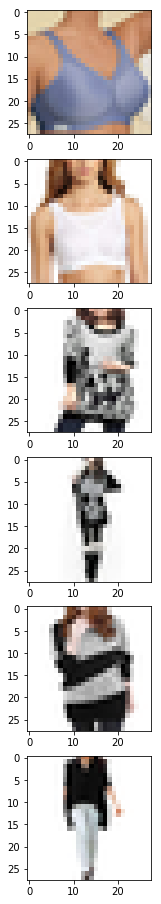

In [90]:
i=21
target_user = user_item_pivot_con.index[i]
items_target = user_item_pivot.loc[target_user]
items_target = items_target.reset_index()
items_target_rated = items_target[~(items_target[target_user].isna())]
images = []
for j in items_target_rated['Item_Id']:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Display items recommended for user

['B00E1JOUOS', 'B007WAU2OK', 'B002QR7HXS', 'B00FEEA4MG', 'B0041FI6N8']


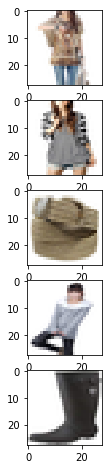

In [89]:
i=21
target_user = user_item_pivot_con.index[i]
items_target = user_item_predicted_con.loc[target_user]
items_target = items_target.reset_index()
top_k_items=top_k_items_recommended(5,target_user,user_item_predicted_con)
print(top_k_items)
images = []
for j in top_k_items:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = len(images) if len(images)<=5 else 5
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Autoencoder model-This section uses the user-item matrix created by item-item neighbours model. We have about 40 training examples of items rated by every user. We use random forest regressor to predict the remaining ratings for each user by training a regression model for each user with training examples of items rated. Each number in vector representation using Autoencoder model is used a feature and the rating is the label. We have the vector representation of all images. Thus the model predicts the rating for unrated items based on its vector represenation

#### Create a copy of user-item matrix predicted by item-item neighbours model

In [58]:
user_item_pivot_con2 = user_item_pivot_con0.copy(deep=True)

#### Read vector representation of each item based on image

In [59]:
feature_df2 = pd.read_csv("item_vector_image3.csv")
feature_df2 = feature_df2[["asin","img_vector"]]

In [60]:
feature_df2.head(5)

,asin,img_vector
0,0000031887,"61.04323959350586,10.855009078979492,67.806251..."
1,0123456479,"69.39546203613281,28.37046241760254,44.9137649..."
2,1608299953,"59.34332275390625,30.055545806884766,47.660144..."
3,1617160377,"59.33428192138672,30.18754005432129,47.7793426..."
4,B00001W0KA,"71.78907775878906,10.117408752441406,79.442283..."


#### Cross-validation and hyper parameter tuning of Random Forest Regressor model using GridSearchCV

In [61]:
i=20
target_user = user_item_pivot_con2.index[i]
items_target = user_item_pivot_con2.loc[target_user]
items_target = items_target.reset_index()
items_target_na = items_target[items_target[target_user].isna()]
items_target_rated = items_target[~(items_target[target_user].isna())]
features = []
labels = []
for j in items_target_rated['Item_Id']:
    feature = feature_df2.loc[feature_df2['asin'] == j, 'img_vector'].tolist()[0].split(",")
    feature = list(map(float, feature))
    features.append(feature)
    labels.append(user_item_pivot_con2.loc[target_user][j])
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2,4,8,10],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(features,labels)
grid_search.best_params_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  2.8min finished
C:\Users\Kiran\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 200}

#### Create Random Forest Regressor model for each user and predict unrated items

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
for i in range(0,user_item_pivot_con2.shape[0]):
    print("User:",i)
    target_user = user_item_pivot_con2.index[i]
    items_target = user_item_pivot_con2.loc[target_user]
    items_target = items_target.reset_index()
    items_target_na = items_target[items_target[target_user].isna()]
    items_target_rated = items_target[~(items_target[target_user].isna())]
    model = RandomForestRegressor(n_estimators=100,bootstrap=True,max_depth=110,max_features=10,min_samples_leaf=3,min_samples_split=12)
    features = []
    labels = []
    for j in items_target_rated['Item_Id']:
        feature = feature_df2.loc[feature_df2['asin'] == j, 'img_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        features.append(feature)
        labels.append(user_item_pivot_con2.loc[target_user][j])
    model.fit(features, labels)
        
        
        
    for k in items_target_na['Item_Id']:
        feature = feature_df2.loc[feature_df2['asin'] == k, 'img_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        predicted_labels = model.predict([feature])
        user_item_predicted_con2.loc[target_user][k]=predicted_labels[0]
user_item_predicted_con2

User: 0
User: 1
User: 2
User: 3
User: 4
User: 5
User: 6
User: 7
User: 8
User: 9
User: 10
User: 11
User: 12
User: 13
User: 14
User: 15
User: 16
User: 17
User: 18
User: 19
User: 20
User: 21
User: 22
User: 23
User: 24
User: 25
User: 26
User: 27
User: 28
User: 29
User: 30
User: 31
User: 32
User: 33
User: 34
User: 35
User: 36
User: 37
User: 38
User: 39
User: 40
User: 41
User: 42
User: 43
User: 44
User: 45
User: 46
User: 47
User: 48
User: 49
User: 50
User: 51
User: 52
User: 53
User: 54
User: 55
User: 56
User: 57
User: 58
User: 59
User: 60
User: 61
User: 62
User: 63
User: 64
User: 65
User: 66
User: 67
User: 68
User: 69
User: 70
User: 71
User: 72
User: 73
User: 74
User: 75
User: 76
User: 77
User: 78
User: 79
User: 80
User: 81
User: 82
User: 83
User: 84
User: 85
User: 86
User: 87
User: 88
User: 89
User: 90
User: 91
User: 92
User: 93
User: 94
User: 95
User: 96
User: 97
User: 98
User: 99
User: 100
User: 101
User: 102
User: 103
User: 104
User: 105
User: 106
User: 107
User: 108
User: 109
User: 110


User: 831
User: 832
User: 833
User: 834
User: 835
User: 836
User: 837
User: 838
User: 839
User: 840
User: 841
User: 842
User: 843
User: 844
User: 845
User: 846
User: 847
User: 848
User: 849
User: 850
User: 851
User: 852
User: 853
User: 854
User: 855
User: 856
User: 857
User: 858
User: 859
User: 860
User: 861
User: 862
User: 863
User: 864
User: 865
User: 866
User: 867
User: 868
User: 869
User: 870
User: 871
User: 872
User: 873
User: 874
User: 875
User: 876
User: 877
User: 878
User: 879
User: 880
User: 881
User: 882
User: 883
User: 884
User: 885
User: 886
User: 887
User: 888
User: 889
User: 890
User: 891
User: 892
User: 893
User: 894
User: 895
User: 896
User: 897
User: 898
User: 899
User: 900
User: 901
User: 902
User: 903
User: 904
User: 905
User: 906
User: 907
User: 908
User: 909
User: 910
User: 911
User: 912
User: 913
User: 914
User: 915
User: 916
User: 917
User: 918
User: 919
User: 920
User: 921
User: 922
User: 923
User: 924
User: 925
User: 926
User: 927
User: 928
User: 929
User: 930


Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F2ZX4XS,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E
User_Id,,,,,,,,,,,,,,,,,,,,,
A0718784TOWF9DX1DOFD,3.542945,3.588034,3.567479,3.425716,3.556950,3.553879,3.530353,3.470219,3.555382,3.513270,...,3.560007,3.511461,3.360748,3.535832,3.543882,3.569419,3.569962,3.536493,3.406053,3.448117
A100WFKYVRPVX7,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A103979529MRJY0U56QI4,4.370018,4.370018,4.370018,4.370018,4.370018,4.370018,4.370018,4.370018,4.370018,4.370018,...,4.370018,4.370018,4.370018,4.370018,4.370018,4.370018,4.370018,4.370018,4.370018,4.370018
A106GRKSYBW4X4,4.624810,4.624810,4.624810,4.624810,4.616606,4.616606,4.616606,4.624810,4.624810,4.616606,...,4.616606,4.616606,4.624810,4.616606,4.616606,4.624810,4.624810,4.616606,4.624810,4.624810
A1079CQTAUIX6J,4.478155,4.409622,4.439480,4.407098,4.561005,4.559294,4.572383,4.223854,4.425405,4.432868,...,4.292453,4.278638,4.452108,4.336093,4.535440,4.492747,4.583275,4.217406,4.428797,4.452771
A10DB98EONP1XP,4.851918,4.843897,4.849198,4.851405,4.838848,4.849435,4.850339,4.862579,4.834910,4.863503,...,4.863562,4.853763,4.734334,4.870783,4.803676,4.839075,4.854091,4.869177,4.747219,4.850617
A10MN9X0EH4XEH,3.351468,3.394463,3.377572,3.016569,3.308108,3.185630,3.358572,3.482096,3.421161,3.516098,...,3.393391,3.408891,3.080525,3.370514,3.192669,3.398622,3.332961,3.540991,3.059626,3.350603
A10UHQH1YL5Q6B,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A110M2KRZB0IS3,4.264866,4.440773,4.380164,4.237404,4.320518,4.260348,4.273985,4.339861,4.431974,4.208393,...,4.279533,4.163446,4.239731,4.142598,4.175180,4.359149,4.300367,4.188238,4.268475,4.231792


#### Evaluation_metrics

In [63]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predicted_con2)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: A1TPTRMYHOFPES
Predicted Ratings: 4.330506505958403
Original Ratings: 4.0


User ID: A2Q3JAF2FM9O4S
Predicted Ratings: 4.379484736799024
Original Ratings: 3.0


User ID: A26IRZJV6D220M
Predicted Ratings: 3.7945235767996026
Original Ratings: 5.0


User ID: A39J4VW83TK90C
Predicted Ratings: 4.563708603570062
Original Ratings: 5.0


User ID: A1IXH6DG8ORH0U
Predicted Ratings: 4.048473500668035
Original Ratings: 2.0


Root Mean Square Error for Test Data: 1.2531544168195927
Mean Absolute Error for Test Data: 1.0800465126111596


#### Coverage- Print catalog coverage and item coverage

In [64]:
calculate_catalog_coverage(10,user_item_predicted_con2)

0.010224948875255624

In [65]:
calculate_items_coverage(10,user_item_predicted_con2)

['B00005TQI7', 'B00006XXGO', 'B000072UMJ', 'B000074RL3', 'B0000868O9', 'B000086910', 'B00008ECKG', 'B00008KH9C', 'B00009ZM7Z', 'B0000ANDU4', 'B0000ANECK', 'B0000ANHST', 'B0000AT7N2', 'B0000ATP8L', 'B0000B35D8', 'B0000C321X', 'B0000V9E3S', 'B0000WLSCW', 'B0000ZBSBU', 'B0000ZBSGU', 'B0000ZDSDG', 'B0000ZEPGA', 'B00012O12A', 'B000163G90', 'B00016QOTE', 'B000196UJ0', 'B0001HKKPW', 'B0001MQ60A', 'B0001YR54O', 'B0001YRJSG', 'B0001YS3NG', 'B0001YSBEW', 'B0001ZNZF6', 'B0001ZNZJM', 'B00020BFSE', 'B00022JPNE', 'B00028B4U0', 'B0002FHIM6', 'B0002M7PWW', 'B0002MGM30', 'B0002QTQA2', 'B0002TOS7A', 'B0002TOZ1E', 'B0002TOZ1Y', 'B0002USAW8', 'B0002VN5KY', 'B0002XSXWC', 'B00031XFL2', 'B00062NOFU', 'B0006AAS7E', 'B0006B58LO', 'B0006I3SBY', 'B0006I49Y4', 'B0006IT6JC', 'B0006LJLMG', 'B0006LMBJ6', 'B0006MY4EU', 'B0006U67WE', 'B00075ZWR4', 'B00075ZYRW', 'B00079UM2A', 'B0007CKMA4', 'B0007KPPAI', 'B0007LPM3W', 'B0007MCUTK', 'B0007PQHXW', 'B0007QCOTM', 'B0007QCQGI', 'B0007QMK2S', 'B0007SUEVA', 'B0007TLLAC', 'B000

0.9969325153374233

#### Qualitative Results

#### Display items bought by user

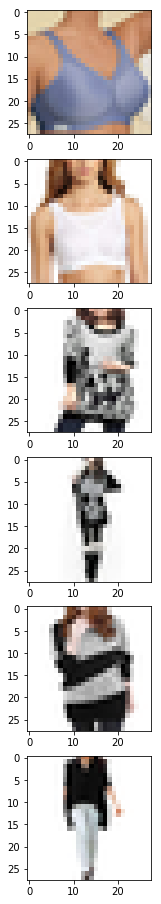

In [88]:
i=21
target_user = user_item_pivot_con2.index[i]
items_target = user_item_pivot.loc[target_user]
items_target = items_target.reset_index()
items_target_rated = items_target[~(items_target[target_user].isna())]
images = []
for j in items_target_rated['Item_Id']:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Display items recommended for user

['B00480ERM0', 'B001V7UAZ6', 'B00005TQI7', 'B006H1CIT2', 'B0064HGDC2']


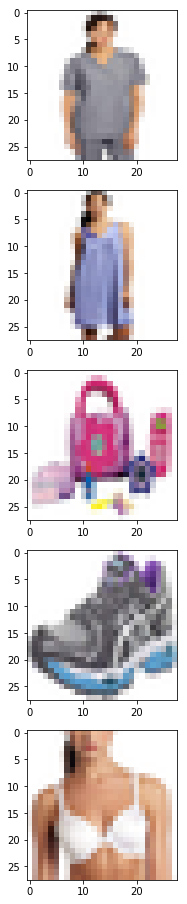

In [87]:
i=21
target_user = user_item_pivot_con2.index[i]
items_target = user_item_predicted_con2.loc[target_user]
items_target = items_target.reset_index()
top_k_items=top_k_items_recommended(5,target_user,user_item_predicted_con2)
print(top_k_items)
images = []
for j in top_k_items:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Combine doc2vec based and autoencoder based content based recommendation results

In [68]:
user_item_predicted_con_hybrid = (user_item_predicted_con+user_item_predicted_con2)/2

In [69]:
user_item_predicted_con_hybrid

Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F2ZX4XS,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E
User_Id,,,,,,,,,,,,,,,,,,,,,
A0718784TOWF9DX1DOFD,3.523706,3.547961,3.537796,3.468885,3.529962,3.543255,3.546768,3.487177,3.552691,3.526982,...,3.522115,3.484807,3.429457,3.519435,3.545802,3.553081,3.532811,3.533102,3.445141,3.416100
A100WFKYVRPVX7,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A103979529MRJY0U56QI4,4.363309,4.363309,4.367990,4.363309,4.363309,4.363309,4.367990,4.363309,4.367990,4.364656,...,4.364656,4.367990,4.359975,4.359975,4.359975,4.367990,4.363309,4.363309,4.364656,4.359975
A106GRKSYBW4X4,4.501484,4.593381,4.662635,4.514124,4.645476,4.611005,4.670538,4.550154,4.591326,4.639520,...,4.674873,4.586428,4.590417,4.648466,4.693529,4.632845,4.511184,4.505357,4.715745,4.687143
A1079CQTAUIX6J,4.365384,4.515658,4.476863,4.335816,4.564007,4.509263,4.521477,4.380051,4.475171,4.451204,...,4.415195,4.366639,4.502507,4.382179,4.498652,4.395452,4.459298,4.261042,4.397145,4.456477
A10DB98EONP1XP,4.851725,4.829424,4.849853,4.850150,4.835144,4.836197,4.837643,4.841378,4.831209,4.847240,...,4.847468,4.846452,4.776409,4.857713,4.824665,4.845612,4.845135,4.853100,4.757469,4.840792
A10MN9X0EH4XEH,3.404158,3.382722,3.342203,3.289144,3.310937,3.157578,3.308676,3.435247,3.390775,3.429972,...,3.361114,3.382731,3.169298,3.278877,3.289749,3.298083,3.372724,3.533558,3.141392,3.329896
A10UHQH1YL5Q6B,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A110M2KRZB0IS3,4.246132,4.435639,4.366923,4.232575,4.330523,4.282131,4.235748,4.404048,4.379539,4.328503,...,4.352462,4.247805,4.389806,4.237064,4.213723,4.198560,4.354118,4.340530,4.251383,4.253075


#### Evaluation metrics

In [70]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predicted_con_hybrid)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: A1TPTRMYHOFPES
Predicted Ratings: 4.181461514546297
Original Ratings: 4.0


User ID: A2Q3JAF2FM9O4S
Predicted Ratings: 4.421848278047218
Original Ratings: 3.0


User ID: A26IRZJV6D220M
Predicted Ratings: 4.029973628259059
Original Ratings: 5.0


User ID: A39J4VW83TK90C
Predicted Ratings: 4.464312199574948
Original Ratings: 5.0


User ID: A1IXH6DG8ORH0U
Predicted Ratings: 3.9518042024534465
Original Ratings: 2.0


Root Mean Square Error for Test Data: 1.1909687681177314
Mean Absolute Error for Test Data: 1.0121656334425908


#### Coverage

In [71]:
calculate_catalog_coverage(10,user_item_predicted_con_hybrid)

0.010224948875255624

In [72]:
calculate_items_coverage(10,user_item_predicted_con_hybrid)

['B00005TQI7', 'B00006XXGO', 'B000072UMJ', 'B000074RL3', 'B0000868O9', 'B000086910', 'B00008ECKG', 'B00008KH9C', 'B00009ZM7Z', 'B0000ANDU4', 'B0000ANECK', 'B0000ANHST', 'B0000AT7N2', 'B0000ATP8L', 'B0000B35D8', 'B0000C321X', 'B0000V9E3S', 'B0000WLSCW', 'B0000ZBSBU', 'B0000ZBSGU', 'B0000ZDSDG', 'B0000ZEPGA', 'B00012O12A', 'B000163G90', 'B00016QOTE', 'B000196UJ0', 'B0001HKKPW', 'B0001MQ60A', 'B0001YR54O', 'B0001YRJSG', 'B0001YS3NG', 'B0001YSBEW', 'B0001ZNZF6', 'B0001ZNZJM', 'B00020BFSE', 'B00022JPNE', 'B00028B4U0', 'B0002FHIM6', 'B0002M7PWW', 'B0002MGM30', 'B0002QTQA2', 'B0002TOS7A', 'B0002TOZ1E', 'B0002TOZ1Y', 'B0002USAW8', 'B0002VN5KY', 'B0002XSXWC', 'B00031XFL2', 'B00062NOFU', 'B0006AAS7E', 'B0006B58LO', 'B0006I3SBY', 'B0006I49Y4', 'B0006IT6JC', 'B0006LJLMG', 'B0006LMBJ6', 'B0006MY4EU', 'B0006U67WE', 'B00075ZWR4', 'B00075ZXLE', 'B00075ZYRW', 'B00079UM2A', 'B0007CKMA4', 'B0007KPPAI', 'B0007LPM3W', 'B0007MCUTK', 'B0007PQHXW', 'B0007QCOTM', 'B0007QCQGI', 'B0007QMK2S', 'B0007SUEVA', 'B000

0.9989775051124744

#### Qualitative Results

#### Display items bought by user

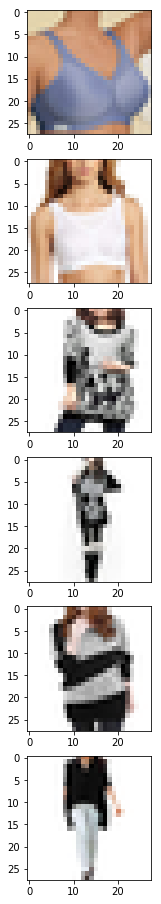

In [86]:
i=21
target_user = user_item_pivot_con.index[i]
items_target = user_item_pivot.loc[target_user]
items_target = items_target.reset_index()
items_target_rated = items_target[~(items_target[target_user].isna())]
images = []
for j in items_target_rated['Item_Id']:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Display items recommended for user

['B007WAU2OK', 'B00E1JOUOS', 'B002QR7HXS', 'B00FEEA4MG', 'B0041FI6N8']


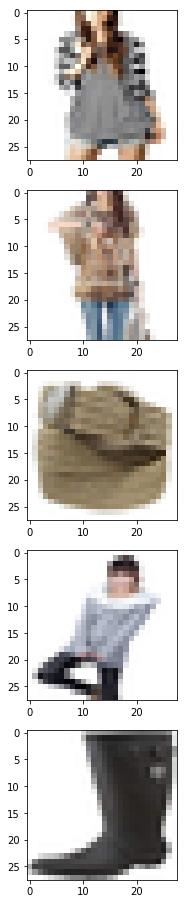

In [85]:
i=21
target_user = user_item_pivot_con.index[i]
items_target = user_item_predicted_con_hybrid.loc[target_user]
items_target = items_target.reset_index()
top_k_items=top_k_items_recommended(5,target_user,user_item_predicted_con_hybrid)
print(top_k_items)
images = []
for j in top_k_items:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()